In [16]:
import pandas as pd
data = pd.read_excel('../附件5-新品历史出货量表.xlsx')

In [17]:
ret = []
for i in data['seller_no'].value_counts().index:
    for j in data['warehouse_no'].value_counts().index:
            ret.append(data[(data['seller_no'] == i) & (data['warehouse_no'] == j)])

In [19]:
k = 0
for i in ret:
    for j in i['product_no'].value_counts().index:
        i[(i['product_no'] == j)].sort_values(by = 'date').to_csv(f'time/time{k}.csv', index = False)
        k += 1

In [20]:
import tsfresh
import pandas as pd
import numpy as np
import warnings 
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()
warnings.filterwarnings('ignore')
for i in range(210):
    data = pd.read_csv(f'No_abnormality_time/time{i}.csv')
    data['id'] = i
    if i == 0:
        df = data.copy()
    else:
        df = df.merge(data, how = 'outer', on = df.columns.to_list())
df.loc[:, ['id', 'qty', 'date' ]].to_csv('time.csv', index = False)

In [21]:
from tsfresh.feature_extraction import extract_features
data = pd.read_csv('time.csv')[['id', 'date', 'qty']]
ret = extract_features(data, default_fc_parameters=settings, column_id="id", column_sort="date")
ret.to_csv('time_feature_min.csv', index=False)

Feature Extraction: 100%|██████████| 35/35 [00:03<00:00, 10.77it/s]


In [22]:
import pandas as pd
data = pd.read_csv('time_feature_min.csv')
data2 = pd.read_excel('../附件2-商品信息表.xlsx')
data3 = pd.read_excel('../附件3-商家信息表.xlsx')
data4 = pd.read_excel('../附件4-仓库信息表.xlsx')

for i in range(210):
    temp = pd.read_csv(f'No_abnormality_time/time{i}.csv')
    v = data3[data3['seller_no'] == temp.iloc[0, 0]]
    for j in ['seller_category', 'inventory_category', 'seller_level']:
        data.loc[i, j] = v[j].values[0]
    v = data2[data2['product_no'] == temp.iloc[0, 2]]
    for j in ['category1', 'category2', 'category3']:
        data.loc[i, j] = v[j].values[0]
    v = data4[data4['warehouse_no'] == temp.iloc[0, 1]]
    for j in ['warehouse _category', 'warehouse _region']:
        data.loc[i, j] = v[j].values[0]

In [23]:
data.to_csv('time_feature_finish.csv', index=False)

In [24]:
import pandas as pd
data_ = pd.read_csv('time_feature_finish.csv')[['qty__standard_deviation', 'qty__mean', 'seller_level', 'warehouse _region', 'category1']]
data_ = pd.get_dummies(data_)

In [25]:
data_ = data_.drop(labels='seller_level_New', axis = 1)
for i in ['category1_传统滋补', 'category1_家庭清洁/纸品','category1_珠宝首饰',
       'category1_运动户外','category1_酒类', 'category1_鲜花/奢侈品']:
    data_[i] = False

In [26]:
data_ = data_[['qty__standard_deviation', 'qty__mean', 'seller_level_Large',
       'seller_level_Medium', 'seller_level_Small', 'seller_level_Special',
       'warehouse _region_东北', 'warehouse _region_华东', 'warehouse _region_华中',
       'warehouse _region_华北', 'warehouse _region_华南', 'warehouse _region_西北',
       'warehouse _region_西南', 'category1_个人护理', 'category1_传统滋补',
       'category1_厨具', 'category1_宠物生活', 'category1_家具', 'category1_家庭清洁/纸品',
       'category1_家用电器', 'category1_家装建材', 'category1_手机通讯', 'category1_数码',
       'category1_服饰内衣', 'category1_玩具乐器', 'category1_珠宝首饰', 'category1_生活日用',
       'category1_电脑、办公', 'category1_美妆护肤', 'category1_运动户外', 'category1_酒类',
       'category1_食品饮料', 'category1_鲜花/奢侈品']]

In [27]:
import pickle
model = pickle.load(open('K-meas.pkl', 'rb'))

In [28]:
data_['label'] = model.predict(data_)
data_.to_csv('time_cluster.csv', index = False)


In [29]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [97]:
import numpy as np
import pandas as pd
import pickle
labels = pd.read_csv('time_cluster.csv')['label']

index = pd.Series(np.arange(0, 210))
r = []
for i in range(0, 7):
    ret = []
    for j in index[(labels == i)]:
        data_ = pd.read_csv(f'No_abnormality_time/time{j}.csv')
        n_in = 30
        n_out = 15
        # 将时序数据转换为监督问题数据
        reframed = series_to_supervised(data_.qty.values.reshape(-1, 1), n_in, n_out)    
        
        ret.append(reframed)
    new = pd.concat(ret)
    new['label'] = i
    r.append(new)
pickle.dump(pd.get_dummies(pd.concat(r), columns=['label']), open(f'timeseries.pkl', 'wb'))

In [98]:
import numpy as np
import pandas as pd
import pickle
labels = pd.read_csv('time_cluster.csv')['label']

index = pd.Series(np.arange(0, 210))
r = []
for i in range(0, 7):
    ret = []
    for j in index[(labels == i)]:
        data_ = pd.read_csv(f'No_abnormality_time/time{j}.csv')
        n_in = 30
        n_out = 0
        # 将时序数据转换为监督问题数据
        reframed = series_to_supervised(data_.qty[-31:].values.reshape(-1, 1), n_in, n_out)    
        reframed['product_no'] = data_['product_no']
        reframed['seller_no'] = data_['seller_no']
        reframed['warehouse_no'] = data_['warehouse_no']
        ret.append(reframed)
    new = pd.concat(ret)
    new['label'] = i
    r.append(new)
pickle.dump(pd.get_dummies(pd.concat(r), columns=['label']).dropna(), open(f'timeseries_test.pkl', 'wb'))

In [132]:
import pandas as pd
import pickle
data = pd.read_pickle('timeseries_test.pkl')
train_data = pd.read_pickle('timeseries.pkl')
y = train_data.iloc[:, 30:-7].values
x = train_data.drop(columns=train_data.iloc[:, 30:-7].columns)
model = pickle.load(open('lightgbm.pkl', 'rb'))
# model.fit(x, y)
x = pd.concat([data.iloc[:, :30], data.iloc[:, -7:]], join='outer', axis=1)
y_pred = model.predict(x)
print(x)
ret = []
for i, j in zip(y_pred, data.iloc[:, 30:-7].values):
    _ = pd.DataFrame({'forecast_qty': i, 'date': [f'2023/5/{k}' for k in range(16, 31)]})
    _['product_no'] = j[0]
    _['seller_no'] = j[1]
    _['warehouse_no'] = j[2]
    ret.append(_)
pd.concat(ret)[['seller_no', 'product_no', 'warehouse_no', 'date', 'forecast_qty']].to_excel('结果2-预测结果表.xlsx')

    var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30         5.0         7.0         8.0         6.0         7.0        10.0   
30        14.0        11.0        17.0        12.0         8.0        10.0   
30         9.0         6.0         8.0         6.0         3.0         3.0   
30         3.0         2.0         2.0         5.0         1.0         5.0   
30         3.0         4.0         3.0         1.0         5.0         3.0   
..         ...         ...         ...         ...         ...         ...   
30         0.0         0.0         1.0         1.0         0.0         2.0   
30         2.0         2.0         0.0         0.0         1.0         1.0   
30         1.0         7.0         3.0         1.0         2.0         1.0   
30         0.0         0.0         0.0         0.0         0.0         0.0   
30         1.0         0.0         0.0         1.0         0.0         0.0   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  ...  var1(t

In [145]:
_ = pd.read_csv(f'No_abnormality_time/time{0}.csv', index_col=3)
_p = pd.read_excel('结果2-预测结果表.xlsx', index_col=0)
_p = _p[(_p['product_no'] == 'product_424') & (_p['warehouse_no'] == 'wh_1')]

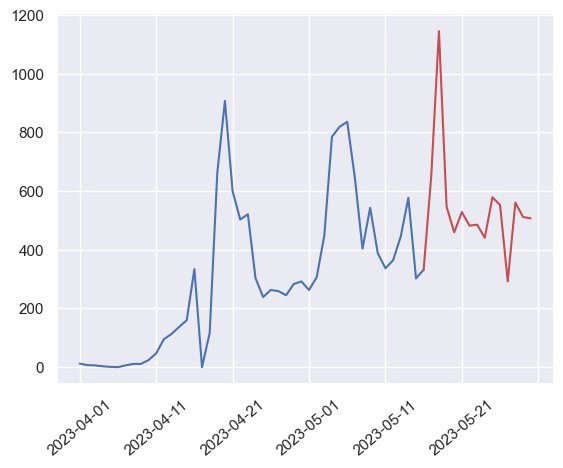

In [151]:
import pylab as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
sns.set(style="darkgrid")
plt.plot(_.index, _.qty, 'b')
plt.plot([f'2023-05-{i}' for i in range(15, 17)], [_.qty[-1], _p['forecast_qty'].values[0]], 'b')
plt.plot([f'2023-05-{i}' for i in range(16, 31)], _p['forecast_qty'].values, 'r')
plt.xticks(rotation=40)
ax = plt.gca()
sns.despine()
ax.xaxis.set_major_locator(MaxNLocator(steps=[2]))
plt.savefig(fname = '第二问时间序列结果.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.0)